In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/Users/hirofumi48/162348.github.io/posts/2024/Stat"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
data = 1 .+ randn(10)
print(data)

[0.29844250276488804, 0.986050219737838, 0.1742550856754621, 0.0759499196458947, 1.1041880106856745, 0.5688430808280789, 2.6096248425837385, 2.6171625575132245, 1.2562007449144053, 1.431280745295334]

In [3]:
#| output: false
using Turing, Distributions, Random

data = [0.99978688, 1.7956116, −0.43158072, 3.07234211, 1.11920946, 0.53248943, 0.80011329, −0.52783428, 0.40378413, −0.00223177]

Random.seed!(123)

prior = MixtureModel([Normal(0.0, 1.0), Normal(0.0, 0.005)], [0.5, 0.5])

@model function mixed_normal_model(data)
    μ ~ prior
    for i in 1:length(data)
        data[i] ~ Normal(μ, 1)
    end
end

model = mixed_normal_model(data)

DynamicPPL.Model{typeof(mixed_normal_model), (:data,), (), (), Tuple{Vector{Float64}}, Tuple{}, DynamicPPL.DefaultContext}(mixed_normal_model, (data = [0.99978688, 1.7956116, -0.43158072, 3.07234211, 1.11920946, 0.53248943, 0.80011329, -0.52783428, 0.40378413, -0.00223177],), NamedTuple(), DynamicPPL.DefaultContext())

In [4]:
#| output: false
chain = sample(model, NUTS(), 100000)

┌ Info: Found initial step size
└   ϵ = 0.8


Sampling:   4%|█▋                                       |  ETA: 0:00:02

Sampling:   8%|███▏                                     |  ETA: 0:00:03

Sampling:  11%|████▌                                    |  ETA: 0:00:02

Sampling:  15%|██████▏                                  |  ETA: 0:00:02

Sampling:  19%|███████▊                                 |  ETA: 0:00:02

Sampling:  22%|█████████▎                               |  ETA: 0:00:02

Sampling:  26%|██████████▋                              |  ETA: 0:00:02

Sampling:  30%|████████████▎                            |  ETA: 0:00:02

Sampling:  34%|█████████████▊                           |  ETA: 0:00:02

Sampling:  38%|███████████████▍                         |  ETA: 0:00:02

Sampling:  41%|████████████████▊                        |  ETA: 0:00:02

Sampling:  45%|██████████████████▌                      |  ETA: 0:00:02

Sampling:  49%|████████████████████▏                    |  ETA: 0:00:01

Sampling:  53%|█████████████████████▊                   |  ETA: 0:00:01

Sampling:  56%|███████████████████████▏                 |  ETA: 0:00:01

Sampling:  60%|████████████████████████▊                |  ETA: 0:00:01

Sampling:  64%|██████████████████████████▎              |  ETA: 0:00:01

Sampling:  68%|███████████████████████████▋             |  ETA: 0:00:01

Sampling:  71%|█████████████████████████████▏           |  ETA: 0:00:01

Sampling:  74%|██████████████████████████████▌          |  ETA: 0:00:01

Sampling:  78%|████████████████████████████████         |  ETA: 0:00:01

Sampling:  82%|█████████████████████████████████▍       |  ETA: 0:00:01

Sampling:  86%|███████████████████████████████████      |  ETA: 0:00:00

Sampling:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

Sampling:  92%|█████████████████████████████████████▉   |  ETA: 0:00:00

Sampling:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

Sampling: 100%|████████████████████████████████████████▊|  ETA: 0:00:00

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (100000×13×1 Array{Float64, 3}):

Iterations        = 1001:1:101000
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 3.39 seconds
Compute duration  = 3.39 seconds
parameters        = μ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse     ess_bulk     ess_tail      rhat ⋯
      Symbol   Float64   Float64   Float64      Float64      Float64   Float64 ⋯

           μ    0.7064    0.3018    0.0017   33306.3728   12033.0664    1.0000 ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           μ    0.1130    0.5029    0.7068    0.9091    1.2988


┌ Warning: `:svg` is not a supported backend.
└ @ Plots ~/.julia/packages/Plots/HyyIK/src/backends.jl:256


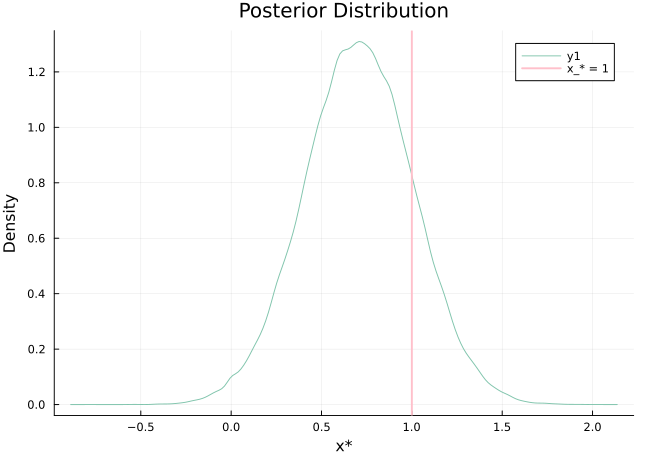

In [5]:
using MCMCChains, Plots, StatsPlots

backend(:svg)

plot(chain[:μ], seriestype = :density, xlabel = "x*", ylabel = "Density", title = "Posterior Distribution", color = "#80c4ac")

vline!([1], color = :pink, linewidth = 2, label = "x_* = 1")

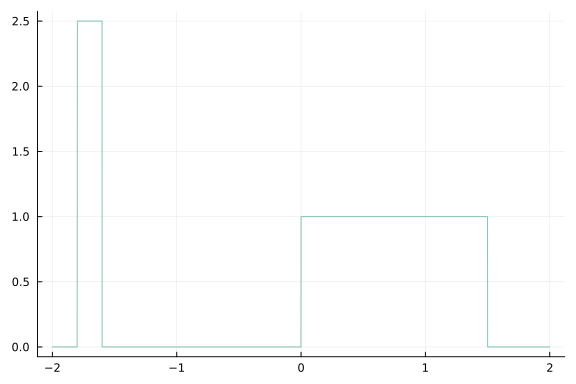

In [6]:
#| code-fold: true
#| label: fig-1
function f(x)
    if -1.8 < x < -1.6
        return 2.5
    elseif 0 < x < 1.5
        return 1
    else 
        return 0
    end
end

plot(f, -2, 2, size=(600, 400), legend=false, color="#80c4ac")